In [20]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import pickle
import glob

### **익절/손절 라인**    

<br> 이번에는 익절/손절라인을 결정할 수 있는 모델을 만들어 보겠습니다. 먼저 피쳐가 있는 데이터를 불러옵니다. 

In [21]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.3%


<br> 날짜와 종목을 인덱스로 설정합니다. 데이터에 예측모델을 적용하고 매수 대상 종목을 select_top 이라는 DataFrame 에 저장합니다. 

In [23]:
mdl_all = feature_all.set_index([feature_all.index,'code'])

with open("gam.pkl", "rb") as file:
    gam = pickle.load(file) 

feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']
X = mdl_all[feature_list]
y = mdl_all['target']

yhat = gam.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

mdl_all['yhat'] = yhat

tops = mdl_all[mdl_all['yhat'] > 0.3].copy()

select_tops = tops[(tops['return'] > 1.03) & (tops['price_z'] < 0)]
print(len(select_tops))

1985


<br> 최저 기대 수익율과 피쳐와의 상관계수를 조사합니다. 예상하지 못햇던 사실은 5 영업일 동안 최저 기대 수익률은 종목보다는 지수 수익률과 더 상관관계가 높습니다. 

In [25]:
select_tops[['return','kosdaq_return','min_close']].corr()['min_close']

return          -0.052747
kosdaq_return    0.152224
min_close        1.000000
Name: min_close, dtype: float64

<br> 'kosdaq_return' 에 따른 최저 기대 수익률의 평균을 구해봅니다. 그래프를 보니 'kosdaq_return'(코스닥 지수 수익률)이 최저 기대수익률과 양의 상관관계가 높은 것으로 나타납니다. 

kosdaq_return
(0.962, 0.999]    0.943243
(0.999, 1.005]    0.957895
(1.005, 1.012]    0.962220
(1.012, 1.026]    0.978050
(1.026, 1.046]    0.974586
Name: min_close, dtype: float64


<AxesSubplot:xlabel='kosdaq_return'>

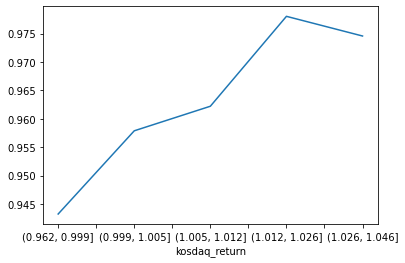

In [26]:
ranks = pd.qcut(select_tops['kosdaq_return'], q=5)
print(select_tops.groupby(ranks)['min_close'].mean())
select_tops.groupby(ranks)['min_close'].mean().plot()

<br> 'kosdaq_return' 값에 따라 아래와 같이 익절/손절 라인을 변동할 수 있도록 합니다. 기본적인 아이디어는 장이 좋을 때는 익절/손절 범위를 늘리고, 안 좋은 날은 익절/손절 범위를 좁히는 것입니다. 아래 함수는 익절 수익률과 손절 수익률을 딕셔너리로 반환합니다.

In [27]:
def profit_loss_cut(x):
    
    if x <= 1.00: # 익절 손절 범위 축소
        return 1.04, 0.98 
    
    elif x <= 1.02: 
        return 1.05, 0.97
    
    else: # 익절/손절범위 확대
        return 1.06, 0.96

<br> 종목 선정 및 익절/손절라인 반환하는 전체 프로세스를 함수를 만듭니다.

In [28]:
def select_stocks_sell(today_dt):
    
    today = datetime.datetime.strptime(today_dt, '%Y-%m-%d')
    start_dt = today - datetime.timedelta(days=100) # 100 일전 데이터 부터 시작 - 피쳐 엔지니어링은 최소 60 개의 일봉이 필요함
    print(start_dt, today_dt)

    kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

    price_data = pd.DataFrame()

    for code, name in zip(kosdaq_list['code'], kosdaq_list['name']):  # 코스닥 모든 종목에서 대하여 반복
        daily_price = fdr.DataReader(code, start = start_dt, end = today_dt) # 종목, 일봉, 데이터 갯수

        daily_price['code'] = code
        daily_price['name'] = name
        price_data = pd.concat([price_data, daily_price], axis=0)   

    price_data.index.name = 'date'
    price_data.columns= price_data.columns.str.lower() # 컬럼 이름 소문자로 변경

    kosdaq_index = fdr.DataReader('KQ11', start = start_dt, end = today_dt) # 데이터 호출
    kosdaq_index.columns = ['close','open','high','low','volume','change'] # 컬럼명 변경
    kosdaq_index.index.name='date' # 인덱스 이름 생성
    kosdaq_index.sort_index(inplace=True) # 인덱스(날짜) 로 정렬 
    kosdaq_index['kosdaq_return'] = kosdaq_index['close']/kosdaq_index['close'].shift(1) # 수익율 : 전 날 종가대비 당일 종가

    merged = price_data.merge(kosdaq_index['kosdaq_return'], left_index=True, right_index=True, how='left')

    return_all = pd.DataFrame()

    for code in kosdaq_list['code']:  

        stock_return = merged[merged['code']==code].sort_index()
        stock_return['return'] = stock_return['close']/stock_return['close'].shift(1) # 종목별 전일 종가 대비 당일 종가 수익율
        c1 = (stock_return['kosdaq_return'] < 1) # 수익율 1 보다 작음. 당일 종가가 전일 종가보다 낮음 (코스닥 지표)
        c2 = (stock_return['return'] > 1) # 수익율 1 보다 큼. 당일 종가가 전일 종가보다 큼 (개별 종목)
        stock_return['win_market'] = np.where((c1&c2), 1, 0) # C1 과 C2 조건을 동시에 만족하면 1, 아니면 0
        return_all = pd.concat([return_all, stock_return], axis=0) 

    return_all.dropna(inplace=True)    

    model_inputs = pd.DataFrame()

    for code, name, sector in zip(kosdaq_list['code'], kosdaq_list['name'], kosdaq_list['sector']):

        data = return_all[return_all['code']==code].sort_index().copy()    

        # 가격변동성이 크고, 거래량이 몰린 종목이 주가가 상승한다
        data['price_mean'] = data['close'].rolling(20).mean()
        data['price_std'] = data['close'].rolling(20).std(ddof=0)
        data['price_z'] = (data['close'] - data['price_mean'])/data['price_std']    
        data['volume_mean'] = data['volume'].rolling(20).mean()
        data['volume_std'] = data['volume'].rolling(20).std(ddof=0)
        data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std']

        # 위꼬리가 긴 양봉이 자주발생한다.
        data['positive_candle'] = (data['close'] > data['open']).astype(int) # 양봉
        data['high/close'] = (data['positive_candle']==1)*(data['high']/data['close'] > 1.1).astype(int) # 양봉이면서 고가가 종가보다 높게 위치
        data['num_high/close'] =  data['high/close'].rolling(20).sum()
        data['long_candle'] = (data['positive_candle']==1)*(data['high']==data['close'])*\
        (data['low']==data['open'])*(data['close']/data['open'] > 1.2).astype(int) # 장대 양봉을 데이터로 표현
        data['num_long'] =  data['long_candle'].rolling(60).sum() # 지난 20 일 동안 장대양봉의 갯 수


         # 거래량이 종좀 터지며 매집의 흔적을 보인다   
        data['volume_mean'] = data['volume'].rolling(60).mean()
        data['volume_std'] = data['volume'].rolling(60).std()
        data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std'] # 거래량은 종목과 주가에 따라 다르기 떄문에 표준화한 값이 필요함
        data['z>1.96'] = (data['close'] > data['open'])*(data['volume_z'] > 1.65).astype(int) # 양봉이면서 거래량이 90%신뢰구간을 벗어난 날
        data['num_z>1.96'] =  data['z>1.96'].rolling(60).sum()  # 양봉이면서 거래량이 90% 신뢰구간을 벗어난 날을 카운트

        # 주가지수보다 더 좋은 수익율을 보여준다
        data['num_win_market'] = data['win_market'].rolling(60).sum() # 주가지수 수익율이 1 보다 작을 때, 종목 수익율이 1 보다 큰 날 수
        data['pct_win_market'] = (data['return']/data['kosdaq_return']).rolling(60).mean() # 주가지수 수익율 대비 종목 수익율


        # 동종업체 수익률보다 더 좋은 수익율을 보여준다.           
        data['return_mean'] = data['return'].rolling(60).mean() # 종목별 최근 60 일 수익율의 평균
        data['sector'] = sector    
        data['name'] = name

        data = data[(data['price_std']!=0) & (data['volume_std']!=0)]    

        model_inputs = pd.concat([data, model_inputs], axis=0)

    model_inputs['sector_return'] = model_inputs.groupby(['sector', model_inputs.index])['return'].transform(lambda x: x.mean()) # 섹터의 평균 수익율 계산
    model_inputs['return over sector'] = (model_inputs['return']/model_inputs['sector_return']) # 섹터 평균 수익률 대비 종목 수익률 계산
    model_inputs.dropna(inplace=True) # Missing 값 있는 행 모두 제거


    feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']

    X = model_inputs.loc[today_dt][['code','name','return','kosdaq_return','close'] + feature_list].set_index('code') 

    with open("gam.pkl", "rb") as file:
        gam = pickle.load(file)     

    yhat = gam.predict_proba(X[feature_list])
    X['yhat'] = yhat

    tops = X[X['yhat'] >= 0.3].sort_values(by='yhat', ascending=False) # 스코어 0.3 이상 종목만 
    print(len(tops))    
  
    select_tops = tops[(tops['return'] > 1.03) & (tops['price_z'] < 0)][['name','return','price_z','yhat','return', 'kosdaq_return','close']]       
    
    #  코스닥 지수에 따라 익절/손절 라인 변경    
    cuts = select_tops['kosdaq_return'].apply(profit_loss_cut)
    
    select_tops['profit_cut'] = [c[0] for c in cuts]
    select_tops['loss_cut']   = [c[1] for c in cuts]    
    
    if len(select_tops) > 1: # 최소한 2개 종목 - 추천 리스크 분산        
        return select_tops    
    
    else:
        return None

<br> 6월 16일 추천종목을 리스트를 추출합니다.

In [37]:
results = select_stocks_sell('2022-06-16')
results.style.set_table_attributes('style="font-size: 12px"').format(precision=3)

2022-03-08 00:00:00 2022-06-16
391


,name,return,price_z,yhat,return,kosdaq_return,close,profit_cut,loss_cut
code,,,,,,,,,
002680,한탑,1.031,-1.282,0.462,1.031,1.003,3155,1.050,0.970
312610,에이에프더블류,1.035,-1.967,0.417,1.035,1.003,3505,1.050,0.970
177350,베셀,1.052,-1.346,0.404,1.052,1.003,7630,1.050,0.970
311390,네오크레마,1.076,-2.141,0.392,1.076,1.003,13450,1.050,0.970
192250,케이사인,1.059,-1.618,0.377,1.059,1.003,1890,1.050,0.970
096870,엘디티,1.082,-1.330,0.373,1.082,1.003,4145,1.050,0.970
067010,이씨에스,1.056,-1.898,0.370,1.056,1.003,3980,1.050,0.970
121600,나노신소재,1.047,-0.602,0.364,1.047,1.003,84600,1.050,0.970
214370,케어젠,1.034,-1.452,0.359,1.034,1.003,96500,1.050,0.970


<br> 예측 스코어가 높은 상위 5 개 종목만 선택합니다.

In [43]:
results2 = results.head(5).style.set_table_attributes('style="font-size: 12px"').format(precision=3)
results2

,name,return,price_z,yhat,return,kosdaq_return,close,profit_cut,loss_cut
code,,,,,,,,,
002680,한탑,1.031,-1.282,0.462,1.031,1.003,3155,1.050,0.970
312610,에이에프더블류,1.035,-1.967,0.417,1.035,1.003,3505,1.050,0.970
177350,베셀,1.052,-1.346,0.404,1.052,1.003,7630,1.050,0.970
311390,네오크레마,1.076,-2.141,0.392,1.076,1.003,13450,1.050,0.970
192250,케이사인,1.059,-1.618,0.377,1.059,1.003,1890,1.050,0.970


<br> 선택된 종목에 익절/손절 라인 값을 딕셔너리로 반환합니다.

In [40]:
select_dict = {}
for code in list(results2.index):
    s = results.loc[code]
    select_dict[code] = [s['name'], s['close'], s['profit_cut'], s['loss_cut']]    

In [41]:
select_dict

{'002680': ['한탑', 3155, 1.05, 0.97],
 '312610': ['에이에프더블류', 3505, 1.05, 0.97],
 '177350': ['베셀', 7630, 1.05, 0.97],
 '311390': ['네오크레마', 13450, 1.05, 0.97],
 '192250': ['케이사인', 1890, 1.05, 0.97]}